# Laboratoire 2
## Gyroscopes à taux (rate gyroscope)

**Matériel nécessaire fourni** : table tournante, surface antidérapante,
règle de 30 cm, masking tape, LEGOs inclinés.

Ce laboratoire utilise le gyro embarqué de la plateforme robotique.
Il s'agit du TDK InvenSense [ICM20948](https://invensense.tdk.com/wp-content/uploads/2024/03/DS-000189-ICM-20948-v1.6.pdf)
<!-- Il s'agit du STMicroelectronics [L3G4200D](http://www.st.com/content/ccc/resource/technical/document/datasheet/04/46/d6/00/be/d9/46/ae/CD00265057.pdf/files/CD00265057.pdf/jcr:content/translations/en.CD00265057.pdf). -->

![img](img/gyro_schema.png)
![img](img/gyro_new_datasheet.png)

### Partie 1 - Familiarisation avec le capteur


In [1]:
# Importation des modules

%load_ext autoreload
%autoreload 2
%matplotlib inline

from robmob.robot import Robot
from robmob.rover.sensors import RobotEspSensor
from robmob.visualization import Visualizer

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Connexion au robot
ip_robot = 'localhost'
robot = Robot(ip_robot)
robot.connect()

Il faut ensuite ajouter le gyroscope aux capteurs écoutés par le robot.

In [3]:
gyro = RobotEspSensor()
robot.add_sensor(gyro)

En guise de *sanity check*, le code suivant affiche la dernière mesure du gyro. Assurez-vous que le robot est immobile avant de prendre la mesure.

In [5]:
gyro.peek_gyro()

{'x': -0.7328244429855966, 'y': -0.5343511518969264, 'z': 5.74809169131774}

Vous devriez remarquer qu'il y a passablement de bruit dans le capteur. Maintenant, installer le robot sur un plateau rotatif et faites le tourner à différentes vitesses. Remarquez le comportement de la mesure en z. Comment se comporte-t-elle à des vitesses de rotation plus élevées?
La valeur en Z augmente.

Le code suivant affiche la mesure en temps réel. Appuyer deux fois sur la touche *i* ou appuyez sur le stop dans le haut de la page pour arrêter la boucle.

In [ ]:
import time
from IPython.display import clear_output

while True:
    mesure = gyro.peek_gyro()
    clear_output(wait=True)
    print("x: %0.10f deg/sec" % mesure['x'])
    print("y: %0.10f deg/sec" % mesure['y'])
    print("z: %0.10f deg/sec" % mesure['z'])
    time.sleep(0.05)

> **NOTE** Selon le manufacturier, le gyroscope est utilisé en mode 250 dps.

### Partie 2 - Calibration du gyroscope
Selon la datasheet, la valeur de Initial ZRO Tolerance, ou *zero-rate output*, se situe entre -5 et 5 dps. Autrement dit, lorsque la plateforme est immobile, la mesure ne sera pas zéro, mais se situera entre -5 et +5 degrés par seconde.
Cette valeur peut varier selon la température à un taux de +/- 0.05 dps/°C.


Pour cette partie, laissez le robot immobile durant 30 secondes.
>**Attention!** Accrocher, faire vibrer (ou même souffler!) sur le capteur faussera le résultat.


In [9]:
samples = gyro.sample_gyro_for_x_sec(30)  # samples a 3 colonnes: x, y et z
z_samples = samples[:, 2]  # notation numpy pour toutes les lignes, colonne 2
print("Dimension de z_samples: ", z_samples.shape)

Dimension de z_samples:  (1875,)


Puisque le roboto se déplace sur un environnement 2D, nous utiliserons uniquement l'axe des z (voir le schéma au haut du notebook).

Offset: 0.9275521518501051


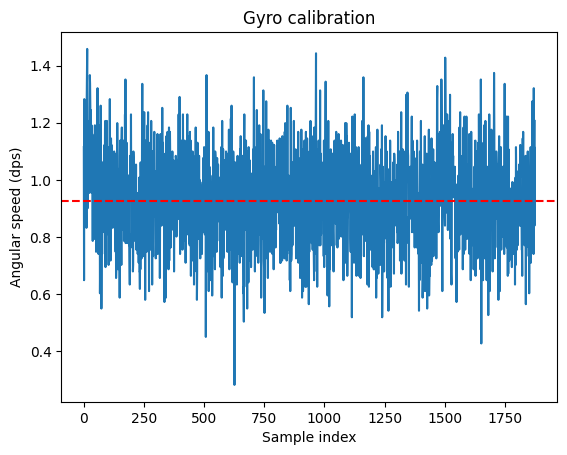

In [10]:
z_offset = np.mean(z_samples)  # TODO
print('Offset:', z_offset)

plt.title('Gyro calibration')
plt.xlabel('Sample index')
plt.ylabel('Angular speed (dps)')
plt.plot(samples[:, 2])
plt.axhline(y=z_offset, color='r', linestyle='--')
plt.show()

Cette valeur `z_offset` permettra d'ajuster les mesures dans les parties suivantes.

### Partie 3 - Intégration des mesures

Dans cette partie, nous allons écrire un programme qui donne l'angle du robot en degré en intégrant les mesures du gyro. Pour ce faire, prenez notes que la frequence d'aquisition des données est 108Hz, tel que stocké dans la constante `gyro.SAMPLE_RATE`. Le temps d'intégration `dt` sera donc `dt = 1 / gyro.SAMPLE_RATE`.

Pour être plus précis avec la fréquence d'échantillonnage, vous pouvez lancer un autre terminal par SSH et exécuter la commande suivante:

```bash
ros2 topic hz /rover/state
```

#### Exercice
Écrivez une fonction qui prend en entrée une mesure du gyro, intègre la mesure angulaire et l'accumule dans une variable `current_angle`. N'oubliez pas de tenir compte du biais `z_offset`.

> **PROTIP** Utilisez l'opérateur modulo % pour ramener l'angle en 0 et 360


In [11]:
current_angle = 0


def integrate_gyro_measure(measure):
    global current_angle
    dt = 1 / gyro.SAMPLE_RATE
    current_angle += dt * (measure - z_offset) % 360
    # modifiez current_angle de sorte qu'il intègre la nouvelle mesure
    # chaque fois que cette fonction est appelée.

In [12]:
# Le programme suivant met à jour current_angle en appelant votre fonction à une fréquence de 108Hz

from IPython.display import clear_output
import time

sleep_time_sec = 1.0 / gyro.SAMPLE_RATE

angle_array = []
vitesse_array = []

def show_robot_angle():
    while True:
        global angle_array
        global vitesse_array
        
        measure = gyro.peek_gyro()['z']  # read_data() retire la donnée lue, peak_data() la laisse dans le buffer
        integrate_gyro_measure(measure)
        
        angle_array.append(current_angle)
        vitesse_array.append(measure)
        
        clear_output(wait=True)
        print(current_angle)
        time.sleep(sleep_time_sec)


show_robot_angle()

-0.0826244513694236


KeyboardInterrupt: 

Pour tester l'intégration des mesures, placez le robot sur un plateau de verre rotatif. Fixez un bout de papier comme point de repère sur le robot et placez le robot au centre de 4 tuiles de plancher (les joints de tuiles représentant 0 deg, 90 deg, 180 deg et 270 deg). Faites tourner le robot et observez les mesures.

> **PROTIP** Il est possible que vous observiez que l'angle dérive rapidement. Ce la peut être causé par un changement de température du robot (voir ZRO Variation Over Temperature dans la datasheet). Si cela est le cas, réévaluez le code de la partie 2 pour recalculer `z_offset`

Maintenant, produisez un graphique montrant la vitesse angulaire du robot en fonction du temps, et un deuxième montrant l'angle du robot dans le temps.

Text(0, 0.5, 'Position (degrees)')

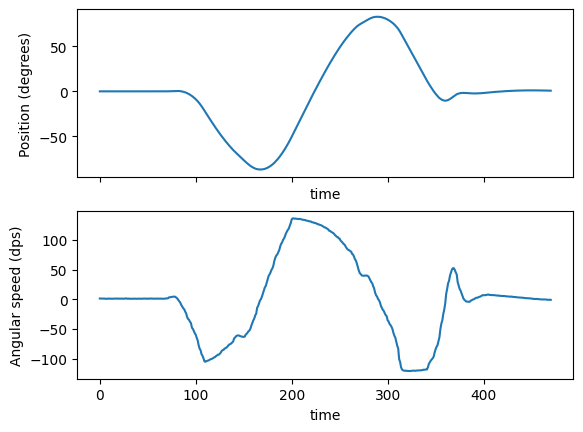

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# TODO graphique vitesse angulaire
ax1.plot(angle_array)
# TODO graphique position
ax2.plot(vitesse_array)

ax2.set_xlabel('time')
ax2.set_ylabel('Angular speed (dps)')

ax1.set_xlabel('time')
ax1.set_ylabel('Position (degrees)')

### Partie 4 - Influence de l'angle du gyroscope


Faites de nouveaux la partie précédente, mais en plaçant le capteur sur un plan
incliné (utilisez les Lego inclinés à cette fin). Faites quelques tours de 360 degrés, toujours en marquant
un tour complet d’une pause de quelques secondes. Comparez les résultats de l'angle final obtenu avec
l'intégration du signal calibré par rapport à un estimé de 360 degrés. En particulier, est-ce
capteur vient changer la mesure?


In [13]:
current_angle = 0
show_robot_angle()

-0.39619081874930456


KeyboardInterrupt: 

angle max: -310.63108299646916


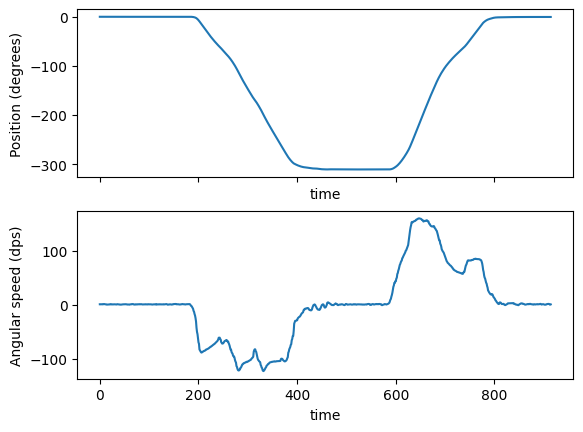

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(angle_array)
ax2.plot(vitesse_array)

ax2.set_xlabel('time')
ax2.set_ylabel('Angular speed (dps)')

ax1.set_xlabel('time')
ax1.set_ylabel('Position (degrees)')

print("angle max:", np.min(angle_array))

### Partie 5 -  Estimation de la dérive du gyroscope

#### Exercice
Orientez le robot dans un angle connu à l'aide d'une référence. Faites une capture d’environ une
minute en vous inspirant du code de la partie 2, pendant laquelle vous faites des rotations horaires et antihoraires de
10-100 degrés autour de cette référence, donc sans jamais compléter un tour. Ceci simulera un robot
qui se déplace en tournant régulièrement, par exemple, mais qui ne fait jamais un tour complet. Avant
la fin de l’enregistrement, revenez exactement à l’angle de référence du départ, et conservez le robot
dans cet angle.
Une fois l’enregistrement terminé, faites l'intégration du signal calibré. S’il n’y avait pas
d’erreur, l’angle du début devrait être le même que celui de la fin. Quelle est l’erreur accumulée
(dérive) sur l’angle que vous constatez?

In [20]:
current_angle = 0
show_robot_angle()

1.946573735601965


KeyboardInterrupt: 

Text(0, 0.5, 'Position (degrees)')

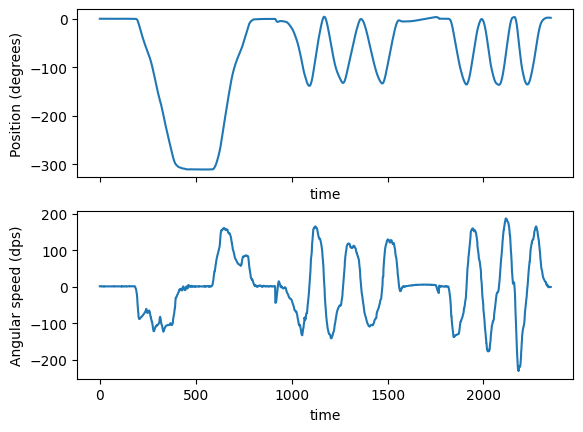

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(angle_array)
ax2.plot(vitesse_array)

ax2.set_xlabel('time')
ax2.set_ylabel('Angular speed (dps)')

ax1.set_xlabel('time')
ax1.set_ylabel('Position (degrees)')

### Partie 6- Impact de mouvements brusques sur l'angle du robot

Capturez des données de gyroscope pendant 30 secondes.
Pendant la capture, faites des mouvements linéaires brusques avec le robot (par exemple, en le déplaçant rapidement d'un côté à l'autre).
Affichez la vitesse angulaire du robot en fonction du temps avec `matplotlib`.
Que constatez-vous?

In [ ]:
# Votre code ici

Maintenant, faites des mouvements de rotation brusques avec le robot (par exemple, en le faisant tourner rapidement sur lui-même).
À la fin de votre capture, le robot devrait être dans la même orientation qu'au début.
Affichez la vitesse angulaire du robot en fonction du temps avec `matplotlib`.
Que constatez-vous?

In [ ]:
# Votre code ici

#### Integration de l'angle avec mouvements de rotation brusques

En utilisant le code d'intégration de l'angle, intégrez les mesures du gyro avec les mouvements de rotation brusques.
Est-ce que le robot revient à son angle initial?

In [ ]:
# Votre code ici

### Partie 7 – Création d’une carte de l’environnement

Vous allez maintenant faire une carte de l'environnement en utilisant le capteur infrarouge et le gyroscope. La carte sera construite en faisant tourner le robot. Ainsi, vous allez
scanner l’environnement en 2D, avec des mesures en coordonnées polaires (i.e. distance et angle).
Déposez la table tournante et le robot sur le plancher. Assurez-vous d’avoir des obstacles intéressants
(boites de carton, poubelle ronde, jambes stables, mur, etc) autour du robot. Assurez-vous également
que tous les obstacles soient situés à 20 cm ou plus du robot (le capteur IR fonctionne pour des
distances de 20-150 cm). Pour tracer cette carte, l'angle du robot est calculé en fonction du temps.Amusez-vous à faire plusieurs cartes en déplaçant les objets entre les scans! Il se peut que des
objets plats apparaissent bombés : ceci sera le symptôme attribuable à la calibration en distance du
capteur infrarouge par défaut dans le script qui est différente de votre capteur.

In [22]:
# Aquisition de 1000 points de la carte à environ 10Hz

import time, math
from robmob.sensors import SharpSensor
from scipy.interpolate import interp1d

# Listes des points de la carte à remplir
map_points = []

# Ajout du capteur sharp
ir_sensor = SharpSensor(0)
robot.add_sensor(ir_sensor)

current_angle = 0
last_measure_time = time.time()

fn_volt_to_cm = interp1d(ir_sensor.HIGH_RANGE_CALIB_TABLE[:, 1], ir_sensor.HIGH_RANGE_CALIB_TABLE[:, 0])

for i in range(200):
    time.sleep(0.1)

    gyro_measures_z = gyro.peek_buffer()[:, 2]
    time_since_last_measure, last_measure_time = time.time() - last_measure_time, time.time()
    number_of_measures = math.floor(time_since_last_measure * gyro.SAMPLE_RATE)

    #Intégration des dernière mesures depuis la dernière mise-à-jour
    current_angle += np.sum((gyro_measures_z[-number_of_measures:] - z_offset) * (1 / gyro.SAMPLE_RATE))

    current_ir_volt = ir_sensor.peek_gyro()
    map_points.append([math.radians(current_angle), fn_volt_to_cm(current_ir_volt)])

ImportError: cannot import name 'SharpSensor' from 'robmob.sensors' (/home/norlab/glo4001/robmob/sensors.py)

In [ ]:
# Affichage de la carte
import matplotlib.pyplot as plt

points = np.asarray(map_points)

fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))

ax.grid(True)
ax.set_ylim(0.0, 200.0)  # Changez cette valeur pour "zoomer" sur les environs du robot
ax.scatter(points[:, 0], points[:, 1])